<a href="https://colab.research.google.com/github/lapshinaaa/deep-learning-tasks/blob/main/DL6_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Diffusion Models`

**Assignment Plan**

We will implement our own diffusion model with experiment logging and first test it on Swiss Roll data, then run it on MNIST.

**Goal of the Assignment**

The goal of this assignment is to understand how diffusion models work and to carefully go through the underlying mathematical formulas.  
At the same time, training difficulties should be minimal.

## Logging

As an initial task, you need to extend the provided code with experiment logging using  
`wandb` or any other similar logging service.

### What can be logged
- Main hyperparameters (learning rate, batch size, number of diffusion steps, diffusion schedule, etc.)
- Loss values
- Gradient norms
- Model parameters and architecture
- Weight distributions
- Generated samples
- Hardware characteristics  
In general — log everything you can reasonably log.

## Imports and SwissRolls

In [3]:
!wget --quiet --show-progress "https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall24/homework04/utils.py"

utils.py            100%[===================>]   6.55K  --.-KB/s    in 0s      


In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

In [2]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
from sklearn.datasets import make_circles, make_swiss_roll


def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0,
    )
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y


X, y = make_swiss_dataset(2000)

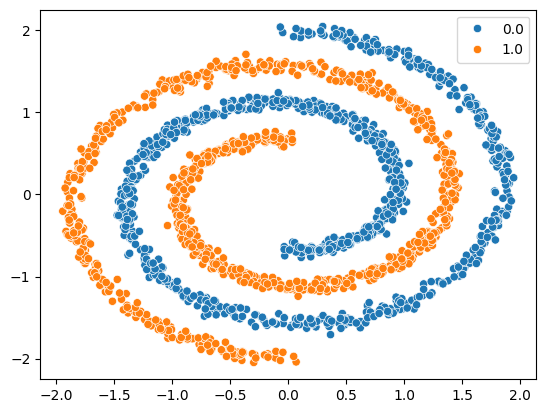

In [6]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

## DDPM

In this part, you will implement your own diffusion model (DDPM) and test it on the dataset described above.

## Reminder

Recall that a diffusion model consists of a forward process and a reverse process.

### Forward Diffusion Process

The forward diffusion process is defined as the posterior distribution  
$q(x_{1:T} \mid x_0)$.  
This distribution is a Markov chain that gradually adds Gaussian noise to an initial object $x_0$.

At each step, noise is added with a different magnitude determined by the variance schedule
$\{\beta_1, \dots, \beta_T\}$.

With a proper choice of the schedule, in the limit as $T \to \infty$, the process converges to pure Gaussian noise $\mathcal{N}(0, I)$.

The forward distributions $q$ are chosen to be Gaussian:

$$
q(x_t \mid x_{t-1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I),
\quad \quad
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

---

### Reverse Diffusion Process

The reverse process denoises noise until an object from the original data distribution is obtained.

Thus, a diffusion model is a probabilistic latent variable model of the form:

$$
p_\theta(x_0) := \int p_\theta(x_{0:T}) \, dx_{1:T}
$$

where the intermediate states $x_1, \dots, x_T$ correspond to noisy versions of the data, and $x_0$ is the clean sample.

The joint distribution $p_\theta(x_{0:T})$ is called the reverse diffusion process, which is also a Markov chain of Gaussian distributions:

$$
p(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t),
\quad \quad
p_\theta(x_T) = \mathcal{N}(x_T \mid 0, I)
$$

$$
p_\theta(x_{t-1} \mid x_t) := \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

---

### Efficient Sampling of the Forward Process

Returning to $q(x_t \mid x_{t-1})$:  
naively, obtaining $x_t$ would require iteratively sampling $x_1, \dots, x_{t-1}$.  
However, due to the Gaussian structure, this can be done more efficiently.

Define:
$$
\alpha_t := 1 - \beta_t,
\quad \quad
\bar{\alpha}_t := \prod_{i=1}^t \alpha_i
$$

Then:
$$
q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
\quad \quad \quad (1)
$$

---

### Training Objective

The model can be trained by optimizing individual terms of the variational lower bound of $\log p_\theta(x_0)$:

$$
L_{VLB} = \mathbb{E}_q \Big[
\underbrace{D_{\text{KL}}(q(\mathbf{x}_T \mid \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T}
+ \sum_{t=2}^T \underbrace{D_{\text{KL}}(q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)
\parallel p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))}_{L_{t-1}}
\underbrace{- \log p_\theta(\mathbf{x}_0 \mid \mathbf{x}_1)}_{L_0}
\Big]
$$

To train the model, it is sufficient to write down:

$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)
= \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I})
$$

with:

$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0)
= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t
+ \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\quad \quad (2)
$$

$$
\tilde{\beta}_t
= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\quad \quad (3)
$$
For more details, see the paper  
[Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239).

---

### Simplified Training Objective

The paper shows that better results are obtained by training with a simpler loss.

Observe that:
$$
x_t(x_0, \epsilon)
= \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon,
\quad \epsilon \sim \mathcal{N}(0, I)
\quad \quad (4)
$$

We let the model with parameters $\theta$ predict the noise $\epsilon$ in the equation above.

The training objective becomes:
$$
L^{\text{simple}}_t
= \mathbb{E}_{x_0, \epsilon, t} \big[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \big]
$$

The intuition is that the KL divergence between Gaussians is proportional to the squared difference between their means, and in this formulation the means are parameterized via $\epsilon$.

This is the loss you must use.

---

### Sampling (Reverse Process)

To sample from the model (reverse diffusion), we need to recover  
$\mu_\theta(x_t, x_0)$ from $\epsilon_\theta(x_t, t)$.

To do this:
1. Compute $\hat{x}_0(\epsilon_\theta, x_t)$ from equation (4)
2. Substitute it into equation (2)

This will be needed to implement `_predict_xstart_from_eps`.

Moving on to the task. Here are two helper functions that we will later use.

In [7]:
# some functions you will need

import math


# utility function. basically, returns arr[timesteps], where timesteps are indices. (look at class Diffusion)
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torch array to extract. (shape is [batch_size])
    :param broadcast_shape: a larger shape of K dimensions; output shape will be broadcasted to this
                            by adding new dimensions of size 1.
                            the first dimension of output tensor will be equal to length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where tensor shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


# our beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "quad":
        betas = (
            torch.linspace(beta_start**0.5, beta_end**0.5, num_diffusion_timesteps) ** 2
        )
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

### Diffusion Class

In [8]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        *,
        betas: np.ndarray, # type: ignore
        loss_type: str = "mse"
    ):
        """
        Class that simulates Diffusion process. Does not store model or optimizer.
        """
        self.loss_type = loss_type

        betas = torch.from_numpy(betas).double()
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - self.betas # todo
        self.alphas = alphas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0) # todo
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)  # \bar\alpha_{t-1}
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([0.0]), ], dim=0)  # \bar\alpha_{t+1}
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)


        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )  # todo, var from (3)

        # log calculation clipped because posterior variance is 0.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]], dim=0)
        )
        self.posterior_mean_coef1 = (self.alphas.sqrt() * (1.0 - self.alphas_cumprod_prev)) / (1.0 - self.alphas_cumprod) # todo, coef of xt from (2)
        self.posterior_mean_coef2 = (self.alphas_cumprod_prev.sqrt() * self.betas) / (1.0 - self.alphas_cumprod) # todo, coef of x0 from (2)

    def q_mean_variance(self, x0, t):
        """
        Get mean and variance of distribution q(x_t | x_0) for specific x_0 and t. Use equation (1).
        """
        alphas_cumprod_sqrt_t = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x0.shape)
        alphas_cumprod_t = _extract_into_tensor(self.alphas_cumprod, t, x0.shape)

        mean = alphas_cumprod_sqrt_t * x0 # todo ; use _extract_into_tensor(*, t, x0.shape) function here and below for getting specific value from *alphas* array
        variance = (1.0 - alphas_cumprod_t) # todo
        log_variance = torch.log(variance) # todo
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0) for specific x_t and t.
        Use equation (2) and (3).

        x_start is x_0 in formulas
        """
        assert x_start.shape == x_t.shape
        coef1 = _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape)
        coef2 = _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape)

        posterior_mean = coef1 * x_t + coef2 * x_start # todo
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse data for a given number of diffusion steps.
        Sample from q(x_t | x_0) use (4).
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_extracted = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_extracted = _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_extracted * x_start + sqrt_one_minus_extracted * noise # todo

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
        """
        alpha_sqrt = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_t.shape)
        one_minus_sqrt = _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)

        return (x_t - one_minus_sqrt * eps) / alpha_sqrt

    def p_mean_variance(self, model_output, x, t): # each timestep corresponds to a different noise level, therefore a different conditional distribution
    # so we're basically recomputing mean and var at every step NOT to discover them but because they're different at each timestep
        """
        Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;
        """
        model_variance = torch.cat([self.posterior_variance[1:2], self.betas[1:]], dim=0)
        model_log_variance = torch.log(model_variance)
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        pred_xstart = self._predict_xstart_from_eps(x, t, model_output)

        coef1 = _extract_into_tensor(self.posterior_mean_coef1, t, x.shape)
        coef2 = _extract_into_tensor(self.posterior_mean_coef2, t, x.shape)

        model_mean = coef1 * x + coef2 * pred_xstart # todo ; don't forget to extract specific values from posterior_mean_coef1 and posterior_mean_coef2 using _extract_into_tensor

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def p_sample(self, model_output, x, t): # every call to p_sample removes a small amount of noise and moves the sample closer to the initial input
        """
        Sample from p(x_{t-1} | x_t).
        """
        out = self.p_mean_variance(model_output, x, t) # todo; get mean, variance of p(xt-1|xt)
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0


        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise # perform one denoising step
        return {"sample": sample}

    def p_sample_loop(self, model, shape, y_dist):
        """
        Samples a batch=shape[0] using diffusion model.
        """

        x = torch.randn(*shape, device=model.device)
        indices = list(range(self.num_timesteps))[::-1]

        y = torch.multinomial(
            y_dist,
            num_samples=shape[0],
            replacement=True
        ).to(x.device)

        for i in tqdm(indices):
            t = torch.tensor([i] * shape[0], device=x.device)
            with torch.no_grad():
                model_output = model(x, t, y)
                out = self.p_sample(
                    model_output,
                    x,
                    t
                )
                x = out["sample"]
        return x, y

    def train_loss(self, model, x0, y):
        """
        Calculates loss L^{simple}_t for the given model, x0.
        """
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)

        noise = torch.randn(size=x0) # todo: sample tensor of shape x0 with noise (from std normal distribution)
        x_t = self.q_sample(x0, t, noise=noise)  # todo use q_sample() to get diffused samples with specific noise
        model_output = model(x_t, t, y) # todo; predict sampled noise from (x_t, t, y)
        if self.loss_type == 'mse':
            loss = F.mse_loss(model_output, noise) # todo; compute mse loss
        else:
            raise NotImplementedError
        return loss

<>:94: SyntaxWarning: invalid escape sequence '\h'
<>:104: SyntaxWarning: invalid escape sequence '\h'
<>:94: SyntaxWarning: invalid escape sequence '\h'
<>:104: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3184917004.py:94: SyntaxWarning: invalid escape sequence '\h'
  Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
/tmp/ipython-input-3184917004.py:104: SyntaxWarning: invalid escape sequence '\h'
  Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;


In [9]:
T = 100

diffusion = Diffusion(betas=get_named_beta_schedule("linear", T), loss_type="mse")

In [10]:
# Check some coeffs (beta version asserts, but they should help)
assert torch.allclose(
    diffusion.alphas_cumprod[[0, 5, 60]],
    torch.DoubleTensor([0.999, 0.9644, 0.0202]),
    rtol=1e-4,
    atol=1e-4,
)


assert torch.allclose(
    diffusion.posterior_mean_coef2[[2, 20, 60]],
    torch.DoubleTensor([0.5562, 0.0928, 0.0188]),
    rtol=1e-4,
    atol=1e-4,
)

In [11]:
# Check some methods (beta version asserts, but they should help)
assert torch.allclose(
    diffusion.q_sample(
        x_start=torch.FloatTensor([[0.1, -0.2, 0.3]]),
        t=torch.LongTensor([[42]]),
        noise=torch.FloatTensor([[0.01, -0.02, 0.1]]),
    )[0],
    torch.FloatTensor([[0.0476, -0.0953, 0.2075]]),
    rtol=1e-4,
    atol=1e-4,
)

assert torch.allclose(
    diffusion.p_mean_variance(
        model_output=torch.FloatTensor([[0.01, -0.21, 0.32]]),
        x=torch.FloatTensor([[0.01, -0.02, 0.1]]),
        t=torch.LongTensor([[42]]),
    )["mean"][0],
    torch.FloatTensor([[0.0095, -0.0006, 0.0736]]),
    rtol=1e-4,
    atol=1e-4,
)

In [12]:
import matplotlib.pyplot as plt


def show_noising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, 10)):
        x = diffusion.q_sample(
            x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )

        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, ax=axs[i])
        axs[i].set(title=t)

Let’s look at how our data gets noised as $t$ increases. Do you think $T = 100$ is enough, or should we increase it? How can we tell what is sufficient?

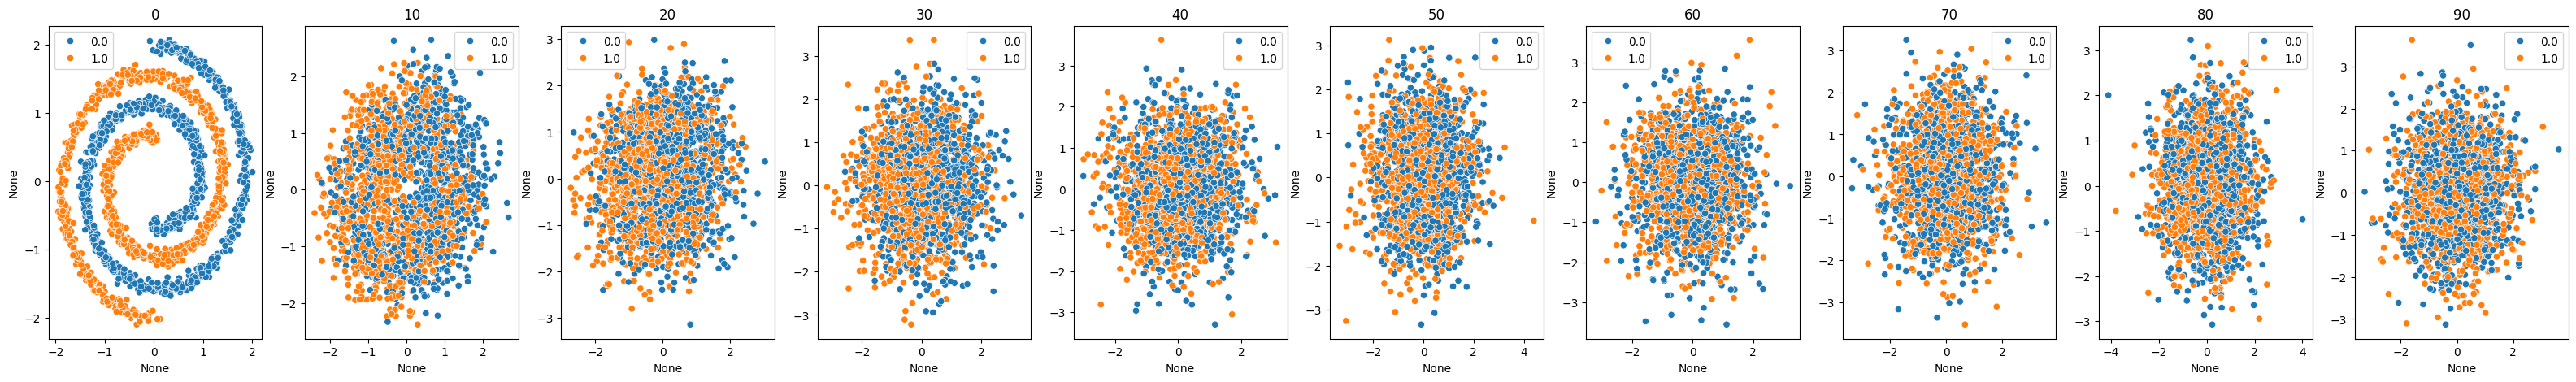

In [13]:
show_noising(diffusion, X, y)

If at $t=T$ the noised Swiss roll still visibly preserves its structure (like it does in this case), that indicates $T=100$ (or the $\beta_t$ schedule) is insufficient: the forward process hasn’t reached something close to $\mathcal{N}(0,I)$. We can judge sufficiency visually (no structure at $t=T$), statistically (mean≈0 and covariance≈I at $t=T$), and analytically via $\bar\alpha_T$: we want $\bar\alpha_T$ to be very small so that the signal term $\sqrt{\bar\alpha_T}x_0$ is negligible.

### Model

Тут мы реализуем модель с весами $\theta$, которая параметризует обратный процесс. Модель не должна быть сложной и большой. Достаточно только линейных слоев. Не забудьте учесть классы $y$ и шаги $t$. Модель предсказывает шум $\epsilon: \epsilon_{\theta}(x_t, t, y)$

In [ ]:
class DiffModel(nn.Module):
    def __init__(self, d_in, num_classes=2):
        super().__init__()

        self.hidden = 128

        # one may use a simple model that projects x and t into space of size self.hidden
        # transforms y label into space of size self.hidden (nn.Embedding), sum all the vectors and postprocess it with MLP
        # try SiLU?? stonks

        self.x_proj = # todo
        self.t_proj = # todo
        self.y_embed = # todo
        self.layers = # todo

    def forward(self, x, t, y):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        :y 1d torch.LongTensor of class labels
        '''
        # todo
        return self.layers(x)

### Обучение модели (1 балл из 7 за DDPM)

Наконец, обучим нашу модель. Ниже за вас написан класс `Trainer`, который хранит модель, диффузию и оптимайзер. Вам надо лишь дописать функцию `_run_step`

In [ ]:
from copy import deepcopy

import pandas as pd


class Trainer:
    def __init__(
        self,
        diffusion: Diffusion,
        model: nn.Module,
        train_iter,  # iterable that yields (x, y)
        lr: float,
        weight_decay: float,
        steps: int,
        device: torch.device = torch.device("cpu"),
    ):
        self.diffusion = diffusion

        self.train_iter = train_iter
        self.steps = steps
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        self.device = device
        self.log_every = 100
        self.print_every = 500

    def _anneal_lr(self, step: int):
        """
        Performs annealing of lr.
        """

        frac_done = step / self.steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor, y: torch.LongTensor):
        """
        A single training step.
        Calculates loss (using Diffusion.train_loss() )for a single batch.
        Then performs a single optimizer step (don't forget to zero grad) and returns loss.
        """
        # todo
        # zero_grad, calc loss, backw

        return loss

    def run_loop(self):
        """
        Training loop.
        """
        step = 0
        curr_loss_gauss = 0.0

        curr_count = 0
        while step < self.steps:
            x, y = next(self.train_iter)
            batch_loss = self._run_step(x, y)

            self._anneal_lr(step)

            curr_count += len(x)
            curr_loss_gauss += batch_loss.item() * len(x)

            if (step + 1) % self.log_every == 0:
                gloss = np.around(curr_loss_gauss / curr_count, 4)
                if (step + 1) % self.print_every == 0:
                    print(f"Step {(step + 1)}/{self.steps} Loss: {gloss}")
                curr_count = 0
                curr_loss_gauss = 0.0

            step += 1

Теперь обернем наши данные в `DataLoader`. Для этого за вас написан `FastTensorDataLoader`. Также у нас идет обучение не по эпохам, а по итерациям, поэтому нам нужен "бесконечный" итератор.

In [ ]:
from utils import FastTensorDataLoader


def get_data_iter(X: np.ndarray, y: np.ndarray, batch_size: int = 512):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    dataloader = FastTensorDataLoader(X, y, batch_size=batch_size, shuffle=True)
    while True:
        yield from dataloader


data_iter = get_data_iter(X, y)

In [ ]:
# you can change hyperparameters
model = DiffModel(d_in=2)
model.device = torch.device("cpu")  # достаточно cpu
trainer = Trainer(
    diffusion, model, train_iter=data_iter, lr=0.01, weight_decay=0.0, steps=6000
)

In [ ]:
trainer.run_loop()  # < 1min

Теперь насэмплируем данные из нашей модели

In [ ]:
from typing import List, Tuple


def sample_synthetic(
    diffusion: Diffusion,
    model: nn.Module,
    num_samples: int,
    batch: int = 1000,
    shape: Tuple = (2,),
    y_dist: List[float] = [0.5, 0.5],
    ddim: bool = False,
):
    sample_func = diffusion.p_sample_loop
    if ddim:  # for the last task
        sample_func = diffusion.ddim_sample
    res_x = []
    res_y = []
    num_sampled = 0
    while num_sampled < num_samples:
        x, y = diffusion.p_sample_loop(
            model, shape=(batch, *shape), y_dist=torch.tensor(y_dist)
        )
        res_x.append(x.cpu())
        res_y.append(y.cpu())
        num_sampled += batch

    res_x = torch.cat(res_x, dim=0)
    res_y = torch.cat(res_y, dim=0)
    return res_x[:num_samples], res_y[:num_samples]

In [ ]:
Xs, ys = sample_synthetic(diffusion, model, 1000)

In [ ]:
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys)

Оцените на глаз, что получилось (должно быть неплохо). Как можно численно оценить качество насэмплированных данных (именно этих данных)?  Пункт не оценивается.

Покажите процесс расшумления аналагично тому, как мы это делали для прямого процесса

In [ ]:
# todo

## MNIST (2 балла)

Перейдём к обучению диффузионной модели на MNIST. За вас уже написана архитектура модели. В данной задаче надо лишь получить относительно *хороший* результат на датасете, используя класс `Diffusion`, а также посмотреть на разные расписания шума.

In [ ]:
from torch.utils.data import DataLoader


class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

In [ ]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import Compose, Lambda, Normalize, ToTensor

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = InfiniteDataLoader(dataset, 512, shuffle=True)

In [ ]:
def show_images(images, ys, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}")
                plt.tick_params(bottom=False, labelbottom=False)
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()


def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:16], batch[1][:16], "Images in the first batch")
        break

In [ ]:
show_first_batch(loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Using device: {device}\t"
    + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")
)

In [ ]:
from utils import MyUNet

model_mnist = MyUNet().to(device)
model_mnist.device = device

### Смотрим на расписание шума

Прежде чем начать, постройте на одной картинке графики $\sqrt{\bar{\alpha_t}}$ (относительно $t$) для различных расписаний (linear, quad, sigmoid). Объясните, чем они отличаются. Чтобы лучше это понять визуализируйте зашумление картинок (функция `show_noising_mnist`). Советую выбрать $T = 1000$ (классический выбор, если домен -- картинки). Данный пункт оценивается.

In [ ]:
def get_alpha_bar(betas):
    # todo

In [ ]:
ts = range(1000)

# your plots here

plt.legend(["linear", "quad", "sigmoid"])

In [ ]:
# almost the same as in the task with SwissRolls

def show_noising_mnist(diffusion, img):
   # todo

In [ ]:
for sch in ["linear", "quad", "sigmoid"]:
    diffusion_temp = Diffusion(
        betas=get_named_beta_schedule(sch, 1000), loss_type="mse"
    )
    show_noising_mnist(diffusion_temp, dataset[0][0])

### Обучаем

In [ ]:
scheduler = # choose your pokemon

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist,
    train_iter=loader,
    lr=0.001,
    steps=1000,
    weight_decay=0.0,
    device=device
)

In [ ]:
trainer_mnist.run_loop()  # <15min on 2080Ti for the author's solution

In [ ]:
Xs, ys = sample_synthetic(
    diffusion_mnist,
    model_mnist,
    num_samples=16,
    batch=16,
    shape=(1, 28, 28),
    y_dist=[0.1 for _ in range(10)],
)

In [ ]:
show_images(Xs, ys)

Оцените качество насэмплированных картинок.

## Бонус (2 балл)

Теперь обучите диффузионку на цветном MNIST. По [ссылке](https://disk.yandex.ru/d/D_7g3UDaYXK4Lg) из домашки с курса "Генеративные модели на основе диффузии" Дениса Ракитина в файле HW1-1.ipynb можно взять класс для цветного MNIST.

In [ ]:
# YOUR CODE HERE

## Отчёт
```(без этой части 0 за дз)```

Напишите отчет по проделанной работе (тут можно написать все, что релевантно к домашке и не забудьте ссылку на wandb или на аналогичный сервис).

```[Отчет должен быть тут]```

## 👀

Вставьте любой мем или анекдот, чтобы поднять настроение проверяющему (если будет смешной, то бонус ```+0.05 балла```).